In [1]:
import numpy as np
import torch
import gymnasium as gym
from torch import nn
from torch.nn import functional as F
import argparse
from torch.utils import tensorboard
from tqdm import tqdm
import os
import random
import time
from dynamics_env.dynamics_rocket import Dynamics
from scipy.integrate import solve_ivp

In [2]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

def strtobool(x):
    if x.lower().strip() == 'true': return True
    else: return False

def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

# Actor module
class Actor(nn.Module):
    def __init__(self, env, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, env.action_space.shape[0] * 2)
        )
        self.out_shape = env.action_space.shape[0]

    def forward(self, X):
        X = self.model(X)
        (means, log_stds) = torch.split(X, [self.out_shape, self.out_shape], dim=-1)
        return means, log_stds.exp()
    
# Critic module
class Critic(nn.Module):
    def __init__(self, env, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [3]:
seed=0
start=None
rocket_mass=433100
destination_type='radius'
destination_params=None
capture_radius=6371e2
orbit_duration=100
orbit_timesteps=1000
dry_mass = rocket_mass * (1 - 0.9)
num_steps = int(orbit_timesteps)
total_timesteps = 8000
v_e=3000

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
print(f'[AGENT] Seed set to {seed}')

device = torch.device( 'cpu')

def make_env(seed):
    def thunk():
        env = Dynamics(hyperparameters={
            'planetary_model_list':['point_source', 'point_source', 'point_source'],
            'planetary_model_kwargs_list':[{'M':2e30, 'period':1e10, 'orbit_radius':0, 'phase':0}, # sun
                                            {'M':1.898e27, 'period':11.86, 'orbit_radius':7.7866e11, 'phase':0.785}, # jupiter
                                            {'M':5.972e24, 'period':1, 'orbit_radius':1.496e11, 'phase':3.945}], # earth
            'seed':seed,
            'max_engine_thrust':7500e3,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

env = make_env(seed=seed)()
assert isinstance(env.action_space, gym.spaces.Box), "must be a continuous action space"

actor = Actor(env, activation=Mish).to(device)
critic = Critic(env, activation=Mish).to(device)
adam_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
start_time = time.time()
episodic_reward = 0
print(f'[AGENT] Using {device}')
if start == None:
    leo_distance = 6371e3 + 300e3 # 300e3 m
    leo_speed = 7.7e3 # 7.7e3 m/s
    earth_orbital_speed = 2.977e4 # m/s
    launch_theta = np.pi / 2 # np.random.rand() * 2 * np.pi * 0
    earth_phase, earth_orbit_radius = env.planetary_models[-1].phase, env.planetary_models[-1].orbit_radius
    launch_position = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
    launch_velocity = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_speed + env.planetary_models[-1].get_velocity(0, earth_orbital_speed)
    launch_mass = np.array([rocket_mass])
    init_params = np.concat([launch_position, launch_velocity, launch_mass])
else: init_params = np.array(start)
if destination_type == 'radius':
    if destination_params == None:
        destination_radius = 35768e3 # geocentric orbit radius
        start_center = np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
        start_radius = 6371e3 + 300e3
    else:
        destination_radius = destination_params[0]
        start_center = destination_params[1]
        start_radius = destination_params[2]
elif destination_type == 'destination_planet':
    if destination_params == None:
        destination_planet_index = len(env.planetary_models)-1
        destination_planet_radius = 6051.8e3 # m (venus)
    else:
        destination_planet_index = destination_params[0]
        destination_planet_radius = destination_params[1]
    start_planet_distance = np.linalg.norm(init_params[:2] - env.planetary_models[destination_planet_index].get_position())
elif destination_type == 'destination':
    if destination_params == None:
        destination_distance = 3 * 1.496e11 # 3au in m
        destination_theta = np.random.rand() * 2 * np.pi # in rad
        destination_radius = 6371e3 # earth radius in m
    else:
        destination_distance = destination_params[0]
        destination_theta = destination_params[1]
        destination_radius = destination_params[2]
    start_destination_distance = np.linalg.norm(init_params[:2] - np.linalg.norm(np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance))
    destination_coords = np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius

[AGENT] Seed set to 0
[AGENT] Using cpu


In [4]:
def clip_grad_norm_(module, max_grad_norm):
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

def policy_loss(old_log_prob, log_prob, advantage, eps):
    ratio = (log_prob - old_log_prob).exp()
    clipped = torch.clamp(ratio, 1-eps, 1+eps)*advantage.unsqueeze(-1)
    
    m = torch.min(ratio*advantage.unsqueeze(-1), clipped)

    with torch.no_grad():
        logratio = log_prob - old_log_prob
        # old_approx_kl = (-logratio).mean()
        approx_kl = ((ratio - 1) - logratio).mean()
        clipfracs = [((ratio - 1.0).abs() > 0.2).float().mean().item()]
    return -m, approx_kl, clipfracs

def reward_function(pos, prev_pos, mass, prev_mass):
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center, axis=-1)
        prev_radius = np.linalg.norm(prev_pos - start_center, axis=-1)
        consistent_reward = (current_radius - prev_radius) / (destination_radius - start_radius) + (mass - prev_mass) / rocket_mass
        completion_reward = current_radius >= destination_radius
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        consistent_reward = (start_planet_distance - np.linalg.norm(planet_position - pos, axis=-1)) / start_planet_distance + (mass - prev_mass) / rocket_mass
        completion_reward = np.linalg.norm(pos - planet_position, axis=-1) < destination_planet_radius
    elif destination_type == 'destination':
        consistent_reward = (start_destination_distance - np.linalg.norm(destination_coords - pos, axis=-1)) / start_destination_distance + (mass - prev_mass) / rocket_mass
        completion_reward = np.linalg.norm(pos - destination_coords, axis=-1) < destination_radius
    # print(consistent_reward)
    # print(completion_reward)
    return consistent_reward + completion_reward

def done_function(pos):
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center)
        completion_reward = current_radius >= destination_radius
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        completion_reward = np.linalg.norm(pos - planet_position) < destination_planet_radius
    elif destination_type == 'destination':
        completion_reward = np.linalg.norm(pos - destination_coords) < destination_radius
    return completion_reward

def event_dest_reached(t, y, thrust):
    pos = y[:2]
    if destination_type == 'radius':
        current_radius = np.linalg.norm(pos - start_center)
        completion = 0 if current_radius >= destination_radius else 1
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position()
        completion = 0 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 1
    elif destination_type == 'destination':
        completion = 0 if np.linalg.norm(pos - destination_coords) < destination_radius else 1
    return completion
event_dest_reached.terminal = True
def rocket_captured(t, y, thrust):
    pos = y[:2]
    min_dist = np.inf
    for model in env.planetary_models:
        dist = np.linalg.norm(pos - model.get_position(t))
        min_dist = min(min_dist, dist)
    return min_dist - capture_radius
rocket_captured.terminal = True

def rocket_function(t, y, thrust):
    # state packaging
    pos = y[:2]
    vel = y[2:4]
    mass = y[-1:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # rocket science
    mdot = -np.linalg.norm(thrust, axis=-1) / v_e # in m/s^2
    delta_m = mdot * orbit_duration / orbit_timesteps
    if (mass - delta_m) < dry_mass:
        a_thrust = np.zeros_like(thrust)
        mdot = 0
    else:
        a_thrust = thrust / mass
    print(vel)
    # derivatives for integrator
    dydt = np.zeros_like(y)
    dydt[:2] = vel
    dydt[2:4] = a_gravity + a_thrust
    dydt[4] = mdot
    return dydt

In [5]:
delta_t = orbit_duration / orbit_timesteps
with tqdm(range(int(total_timesteps)), desc=f'episodic_reward: {episodic_reward}') as progress:
    for i in range(int(total_timesteps)):
        prev_logprob = None
        done = False
        state = torch.tensor(init_params, dtype=torch.float32).to(device)

        observations = torch.zeros((num_steps,)+env.observation_space.shape, dtype=torch.float32).to(device)
        actions = torch.zeros((num_steps,)+env.action_space.shape, dtype=torch.float32).to(device)
        logprobs = torch.zeros((num_steps,)+env.action_space.shape, dtype=torch.float32).to(device)
        rewards = torch.zeros((num_steps,), dtype=torch.float32).to(device)
        dones = torch.zeros((num_steps,), dtype=torch.float32).to(device)
        values = torch.zeros((num_steps,), dtype=torch.float32).to(device)
        clip_fracs = []
        y0 = init_params
        t = 0
        trajectory = [init_params]
        times = [t]
        for j in range(orbit_timesteps):
            # preparing args for solve_ivp
            pos, vel, mass = y0[:2], y0[2:4], y0[-1:]
            a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
            state = env._normalise_state(torch.tensor(np.concat([pos, vel, a_gravity, mass]), dtype=torch.float32, device=device)).float()
            with torch.no_grad():
                action_means, action_stds = actor(state)
            value = critic(state).flatten()
            dist = torch.distributions.Normal(action_means, action_stds)
            action = dist.sample()
            logprob = dist.log_prob(action)
            thrust = env._process_actions(action).float().numpy() # in N (kg m/s^2)
            # orbit step integration
            orbit = solve_ivp(rocket_function, t_span=(t, t + delta_t), y0=y0, t_eval=[t + delta_t], events=[event_dest_reached, rocket_captured], args=(thrust,))
            print(j)
            # PPO
            observations[j] = state
            actions[j] = action
            logprobs[j] = logprob
            dones[j] = torch.tensor(done_function(pos), dtype=torch.float32).to(device)
            reward = reward_function(orbit.y[:2,-1], pos, orbit.y[-1:,-1], mass)
            rewards[j] = torch.tensor(reward, dtype=torch.float32, device=device)
            values[j] = value
            # preparing for next orbit step integration
            y0 = orbit.y[:,-1]
            t = t + delta_t
            trajectory.append(y0)
            times.append(t)
            if done: break
        break
        # advantage calculation
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(done_index)):
            if t == num_steps - 1:
                advantages[t] = lastgaelam = rewards[t] + (1- dones[t]) * gamma * values[t] + gamma * gae_lambda * (1-dones[t]) * lastgaelam
            else:
                advantages[t] = lastgaelam = rewards[t] + (1-dones[t+1]) * gamma * values[t+1] - (1-dones[t])*values[t] + gamma * gae_lambda * (1-dones[t+1]) * lastgaelam  

        action_means, action_stds = actor(observations)
        dist = torch.distributions.Normal(action_means, action_stds)
        new_logprobs = dist.log_prob(actions)
        actor_loss, approx_kl, clipfracs = policy_loss(logprobs, new_logprobs, advantages.detach(), clip_coef)
        actor_loss = actor_loss.mean()
        clip_fracs += clipfracs
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()

        critic_loss = advantages.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()

        if log_train:
            writer.add_scalar("loss/actor_loss", actor_loss.detach(), global_step=i)
            writer.add_histogram("gradients/actor",
                            torch.cat([p.grad.view(-1) for p in actor.parameters()]), global_step=i)
            writer.add_scalar("loss/advantage", advantages.detach().cpu().numpy().mean(), global_step=i)
            writer.add_scalar("reward/episode_reward", rewards.sum(dim=0).max().cpu().numpy(), global_step=i)
            writer.add_scalar("loss/critic_loss", critic_loss.detach(), global_step=i)
            writer.add_histogram("gradients/critic",
                            torch.cat([p.grad.view(-1) for p in critic.parameters()]), global_step=i)
            writer.add_scalar('charts/learning_rate', adam_actor.param_groups[0]['lr'], global_step=i)
            writer.add_scalar('charts/approx_kl', approx_kl.item(), global_step=i)
            writer.add_scalar("charts/clipfrac", np.mean(clip_fracs), global_step=i)
            writer.add_scalar('charts/SPS', int(i/ (time.time() - start_time)), i)
        adam_critic.step()

        episodic_reward = rewards.sum(dim=0).max().cpu().numpy()
        progress.set_description(f'episodic_reward: {episodic_reward}')
        progress.update()

episodic_reward: 0:   0%|          | 0/8000 [00:00<?, ?it/s]

[ 21426.23835086 -12968.07224035]
[ 21427.36034406 -12967.23573007]
[ 21426.4627495  -12967.90493829]
[ 21426.57498355 -12967.82122433]
[ 21427.13619245 -12967.40258451]
[ 21427.23598313 -12967.32812302]
[ 21427.36073008 -12967.23503062]
[ 21427.36073008 -12967.23503062]
0
[ 21427.36073008 -12967.23503062]
[ 21425.97852928 -12968.40440586]
[ 21427.08428992 -12967.46890567]
[ 21426.94604062 -12967.58583966]
[ 21426.25476162 -12968.17050573]
[ 21426.13185057 -12968.27444432]
[ 21425.97820454 -12968.40436668]
[ 21425.97820453 -12968.40436667]
1
[ 21425.97820453 -12968.40436667]
[ 21427.52007973 -12970.22047256]
[ 21426.28657957 -12968.76758785]
[ 21426.44080864 -12968.94921393]
[ 21427.21200017 -12969.85736161]
[ 21427.34912506 -12970.01881912]
[ 21427.52054145 -12970.22064482]
[ 21427.52054145 -12970.22064481]
2
[ 21427.52054145 -12970.22064481]
[ 21425.82456525 -12969.38046781]
[ 21427.18134621 -12970.05260941]
[ 21427.01168686 -12969.96851924]
[ 21426.16332137 -12969.54798776]
[ 21426.

episodic_reward: 0:   0%|          | 0/8000 [00:02<?, ?it/s]

[ 21194.0357186  -13489.74524592]
[ 21197.0693947  -13486.50071777]
[ 21196.6898982  -13486.90652883]
[ 21194.79209573 -13488.93585744]
[ 21194.4545414  -13489.29676978]
[ 21194.03252743 -13489.74797087]
[ 21194.03252742 -13489.74797085]
945
[ 21194.03252742 -13489.74797085]
[ 21193.55066354 -13491.15159516]
[ 21193.93615465 -13490.02869571]
[ 21193.88796236 -13490.16906004]
[ 21193.64699438 -13490.87088376]
[ 21193.6041522  -13490.99565353]
[ 21193.55059802 -13491.1516162 ]
[ 21193.55059802 -13491.15161619]
946
[ 21193.55059802 -13491.15161619]
[ 21191.45329876 -13494.00949632]
[ 21193.13113816 -13491.72319222]
[ 21192.92131428 -13492.00906907]
[ 21191.87209022 -13493.43855226]
[ 21191.68550679 -13493.69273434]
[ 21191.45225426 -13494.01048391]
[ 21191.45225426 -13494.0104839 ]
947
[ 21191.45225426 -13494.0104839 ]
[ 21194.54215168 -13493.67849779]
[ 21192.07023374 -13493.94408668]
[ 21192.37937495 -13493.91082949]
[ 21193.92524964 -13493.74447835]
[ 21194.20016   -13493.7148707]
[ 21

In [6]:
actions

tensor([[ 0.6477,  2.5070],
        [-0.7979, -0.1583],
        [ 0.8891, -0.5314],
        ...,
        [-0.6793, -0.9269],
        [-1.3242,  1.3975],
        [-0.9032,  1.6426]])

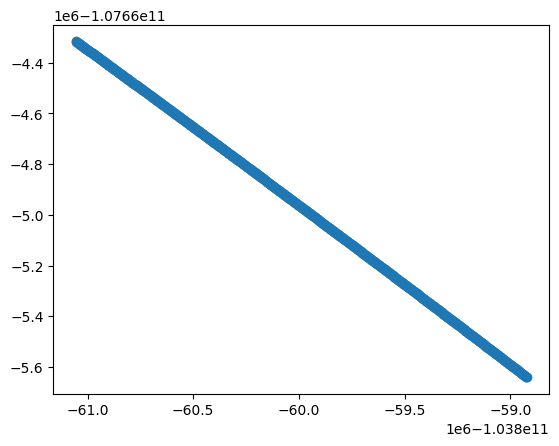

In [7]:
import matplotlib.pyplot as plt
x = np.array(trajectory)[:,0]
y = np.array(trajectory)[:,1]
plt.scatter(x, y)

In [8]:
print(orbit.y[1])

[-1.07665641e+11]
